# Model Creation - 3

### This model will look at local changes in rating, using vintage data to justify these changes

Model 3 takes in training dataset 3. This data is of different bottles, districts, and regions then the previous two models. This model was create to provide more validity to the initial Model 1. Internal discussion was yielded concerns of a the potential bias from using single data point in each region. To help mitigate this, a different filtering was done, taking out more extreme values in the 02_Popular_Wines file. Additionally, more regions and less districts were added to increase weather varaibility. Overall this data set will add the the Model 1 data, confirming some of its legitimacy. 

As a way to internally validate, a completely new model will be create and compared to the Model 1. Accuracy should be similar, and higher as data should remove some of the extreme values predicted to effect the Model 1 data. 

Of important note, the purpose of the 3 machine learning models changed throughout the project. The final purpose of the models is more exploratory, with no predicting actually being done on the data. As such, hyperparamter tuning will be ignored, as the model will not be used within the scope of this project to predict anything. Instead, more focus was given to feature selection and iterating through these to find relevant features. The reason for this is to show the relationship between features and rating, proving that there is a relationship. 

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style = "whitegrid", palette="muted", context="talk")

# Set Matplotlib rcParams
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 20,
    'axes.labelsize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5
})

## Import Data
Start by importing the training and testing data.

In [2]:
train = pd.read_csv(r'C:\Users\fwhal\Downloads\CME528\Project\Repo-2\BreakinBadCode\Final_DataFrames\FINAL_training_data_Model3_FINAL.csv')
train

,Producer,WineType,District,Region,Year,Ratings_Average,January Max Temp (°C),January Min Temp (°C),January Avg Temp (°C),January Max Relative Humidity,...,December Min Wind Speed (Km/h),December Avg Wind Speed (Km/h),December Avg Daylight Hours,December Days Below 0 (°C),December Days Above 32 (°C),Acidity,Intensity,Sweetness,Tannin,Type
0,Silver Oak,cabernet sauvignon,Sonoma,California,2000,4.5,15.054501,-9.245500,0.990253,98.57532,...,1.297998,13.082399,9.496377,24,0,3.5,5.0,1.0,4.0,NaN
1,Silver Oak,cabernet sauvignon,Sonoma,California,2001,4.5,8.704500,-18.745500,-1.446038,100.00000,...,1.297998,13.247615,9.497857,9,0,3.5,5.0,1.0,4.0,wsa_winning
2,Silver Oak,cabernet sauvignon,Sonoma,California,2002,4.5,15.354500,-10.845500,1.155441,98.22413,...,2.595997,12.593289,9.498973,9,0,3.5,5.0,1.0,4.0,NaN
3,Silver Oak,cabernet sauvignon,Sonoma,California,2003,4.6,16.754500,-16.795500,-1.830043,96.79787,...,0.509117,14.246307,9.499961,9,0,3.5,5.0,1.0,4.0,NaN
4,Silver Oak,cabernet sauvignon,Sonoma,California,2004,4.5,16.904501,-15.695499,-1.467946,99.65632,...,0.720000,14.361270,9.495994,9,0,3.5,5.0,1.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Chacra,pinot noir,Güer Aike,Santa Cruz,2018,4.3,31.300000,5.250000,14.094960,88.71973,...,1.080000,25.553717,16.558364,0,0,3.0,3.0,1.0,1.5,NaN
348,Chacra,pinot noir,Güer Aike,Santa Cruz,2019,4.2,26.250000,5.000000,12.493683,88.55247,...,1.484318,26.410897,16.556112,0,0,3.0,3.0,1.0,1.5,most_user_rated
349,Chacra,pinot noir,Güer Aike,Santa Cruz,2020,4.3,25.550000,4.400000,12.294893,96.00224,...,1.440000,28.455424,16.562875,0,0,3.0,3.0,1.0,1.5,NaN
350,Chacra,pinot noir,Güer Aike,Santa Cruz,2021,4.3,26.400000,4.350000,13.717406,89.85642,...,0.360000,27.776740,16.561000,0,0,3.0,3.0,1.0,1.5,best_user_rated


## Exploratory Data Anlysis
Visially and graphically look at data

Looking at the districts below, we can see clear time dependent trends in the data 
- Data looks almost random. Will use weather data to explain trends

In [3]:
train['District'].unique()

array(['Sonoma', 'Tulare', 'Jackson', 'Clay', 'Marion', 'Yamhill',
       'Lincoln', 'Toscana', 'Umbria', 'Piemonte', 'Abruzzo', 'Gironde',
       'Dordogne', "Côte-d'Or", 'Ardèche', 'Rioja, La', 'Burgos',
       'Barossa', 'Onkaparinga', 'Unincorporated SA', 'Yarra Ranges',
       'Thompson--Okanagan', 'San Rafael', 'Luján de Cuyo',
       'Presidente Roque Sáenz Peña', 'Güer Aike'], dtype=object)

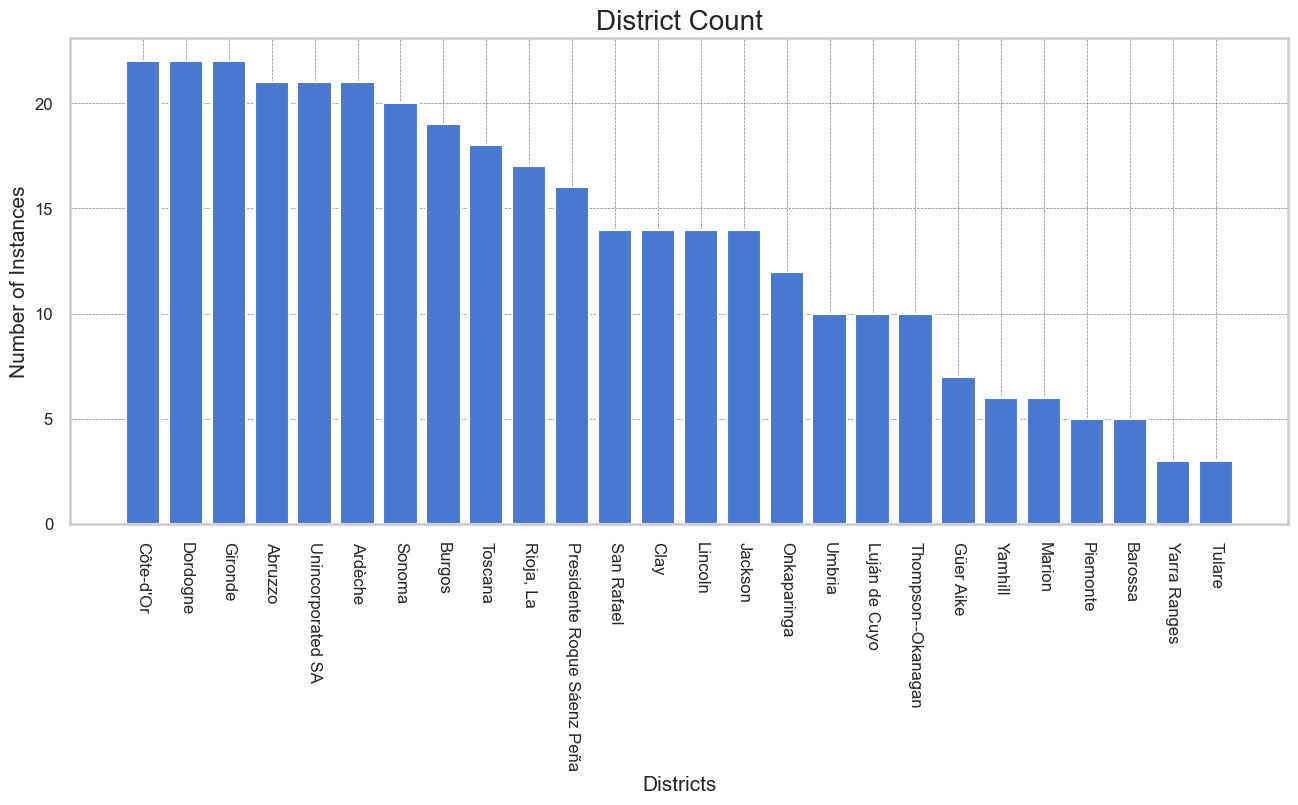

In [4]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Define the data
categories =  train['District'].value_counts()

#Customizing Bar Plot
plt.bar(categories.index, categories.values)

#Adding labels and title
plt.xlabel('Districts')
plt.ylabel('Number of Instances')
plt.title('District Count')

#Rotate data
plt.xticks(rotation=270)

#Show the plot
plt.show()

## Data Cleaning Engineering
Following the input of the data, extensive measurements must be taken to clean and format the data. 

The cleaning process involves: 
- Drops duplicate rows
- NaN values are filled in the training dataset code section



In [5]:
def Cleaning_Data(DataFrame_Clean):
    """
    Input: initial DataFrame data

    Cleans a DataFrame_ through four processes:
        1. Drops duplicate rows
        2. fills NaN values 

    Output: Cleaned DataFrame
    """

    #Drops any rows with the name producer/year
    DataFrame_Clean['Producer_WineType_Year'] = DataFrame_Clean['Producer'] + DataFrame_Clean['WineType'] + DataFrame_Clean['Year'].astype(str)
    DataFrame_Clean = DataFrame_Clean.drop_duplicates(subset = 'Producer_WineType_Year')

    #Drops 'type' columns
    DataFrame_Clean = DataFrame_Clean.drop(columns = ['Type']).dropna()
    

    return DataFrame_Clean

# Feature Engineering

This chunk of code sets out all the features that were considered for the design of a model


In [6]:
def Features(DataFrame):
    """
    Adds all features to the dataframe
    """
    months = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
    seasons = {'Spring' : ['March', 'April', 'May'], 'Summer' : ['June', 'July', 'August'], 'Fall' : ['September', 'October', 'November'], 'Winter' : ['December', 'January', 'February']}

    for month in months: 

        #Add feature for tempxhumidity interaction 
        DataFrame[f'{month}_Temp_Humidity'] = DataFrame[f'{month} Avg Temp (°C)'] * DataFrame[f'{month} Avg Relative Humidity']

    for season in seasons:
    
        #Add feature for seasonal average temperature
        DataFrame[f'{season}_Avg_Temp'] = DataFrame[[f'{month} Avg Temp (°C)' for month in seasons[season]]].mean(axis = 1)

        #Add feature for humidity average temperature
        DataFrame[f'{season}_Avg_Humid'] = DataFrame[[f'{month} Avg Relative Humidity' for month in seasons[season]]].mean(axis = 1)

        #Add feature for seasonal average precip
        DataFrame[f'{season}_Avg_Precip'] = DataFrame[[f'{month} Cumulative Precip (mm)' for month in seasons[season]]].mean(axis = 1)
        
        #Add feature for seasonal average cloud cover
        DataFrame[f'{season}_Avg_Cloud_Cover'] = DataFrame[[f'{month} Avg Cloud Cover (%)' for month in seasons[season]]].mean(axis = 1)

        #Add feature for seasonal daylight hours
        DataFrame[f'{season}_Avg_Daylight_Hrs'] = DataFrame[[f'{month} Avg Daylight Hours' for month in seasons[season]]].mean(axis = 1)
    
        #Add feature for seasonal temp humidity
        DataFrame[f'{season}_Temp_Humidity'] = DataFrame[[f'{month}_Temp_Humidity' for month in seasons[season]]].mean(axis = 1)

        #Add feature for days below 0 per month
        DataFrame[f'{season}_Days_Below_0'] = DataFrame[[f'{month} Days Below 0 (°C)' for month in seasons[season]]].sum(axis = 1)
    
        #Add feature for days above 32 per month
        DataFrame[f'{season}_Days_Above_32'] = DataFrame[[f'{month} Days Above 32 (°C)' for month in seasons[season]]].sum(axis = 1)
    
    #Add feature for annual precip
    DataFrame['Yearly_Precip'] = DataFrame[[f'{month} Cumulative Precip (mm)' for month in months]].sum(axis = 1)

    return DataFrame

## Selecting Features 

The feature selection function takes in all the added features, removing many of the ones that were determined to not help the data well. 
- Removed features were done based on the utility graph later on

In [7]:
def Feature_Selection(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        'Year',

                        # 'Winter_Avg_Temp', 
                        # 'Spring_Avg_Temp',
                        'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)',
                        # 'July Avg Temp (°C)',
                        # 'August Avg Temp (°C)',                                   
                        # 'Fall_Avg_Temp',

                        'Winter_Avg_Humid',
                        'Spring_Avg_Humid',
                        # 'Summer_Avg_Humid',
                        # 'Fall_Avg_Humid',

                        # 'Winter_Avg_Precip', 
                        # 'Spring_Avg_Precip',
                        'Summer_Avg_Precip',
                        # 'Fall_Avg_Precip',

                        # 'Winter_Avg_Cloud_Cover',
                        # 'January Avg Cloud Cover (%)',
                        # 'February Avg Cloud Cover (%)',
                        # 'Spring_Avg_Cloud_Cover',
                        # 'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)',
                        # 'May Avg Cloud Cover (%)',
                        'Summer_Avg_Cloud_Cover',
                        # 'Fall_Avg_Cloud_Cover',

                        'Winter_Avg_Daylight_Hrs',
                        'Spring_Avg_Daylight_Hrs',
                        'Summer_Avg_Daylight_Hrs',
                        # 'Fall_Avg_Daylight_Hrs',

                        # 'Winter_Temp_Humidity',
                        # 'Spring_Temp_Humidity',
                        'Summer_Temp_Humidity',
                        'Fall_Temp_Humidity',

                        # 'Winter_Days_Below_0',
                        # 'Spring_Days_Below_0',
                        # 'Summer_Days_Below_0',
                        # 'Fall_Days_Below_0',
                        
                        # 'Winter_Days_Above_32',
                        # 'Spring_Days_Above_32',
                        # 'Summer_Days_Above_32',
                        # 'Fall_Days_Above_32',

                        'Acidity',
                        'Intensity',
                        # 'Sweetness',
                        'Tannin',
                                                
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data

---

## Global Trends

Thinking high level, how data was created, no normalization occured to ensure that winter months in one country were similar to winter months in another
- as such, preliminary mondels show an accuracy of about xxx with all the data, and xxx when data is separated by more similar countries

In [8]:
train['District'].unique()

array(['Sonoma', 'Tulare', 'Jackson', 'Clay', 'Marion', 'Yamhill',
       'Lincoln', 'Toscana', 'Umbria', 'Piemonte', 'Abruzzo', 'Gironde',
       'Dordogne', "Côte-d'Or", 'Ardèche', 'Rioja, La', 'Burgos',
       'Barossa', 'Onkaparinga', 'Unincorporated SA', 'Yarra Ranges',
       'Thompson--Okanagan', 'San Rafael', 'Luján de Cuyo',
       'Presidente Roque Sáenz Peña', 'Güer Aike'], dtype=object)

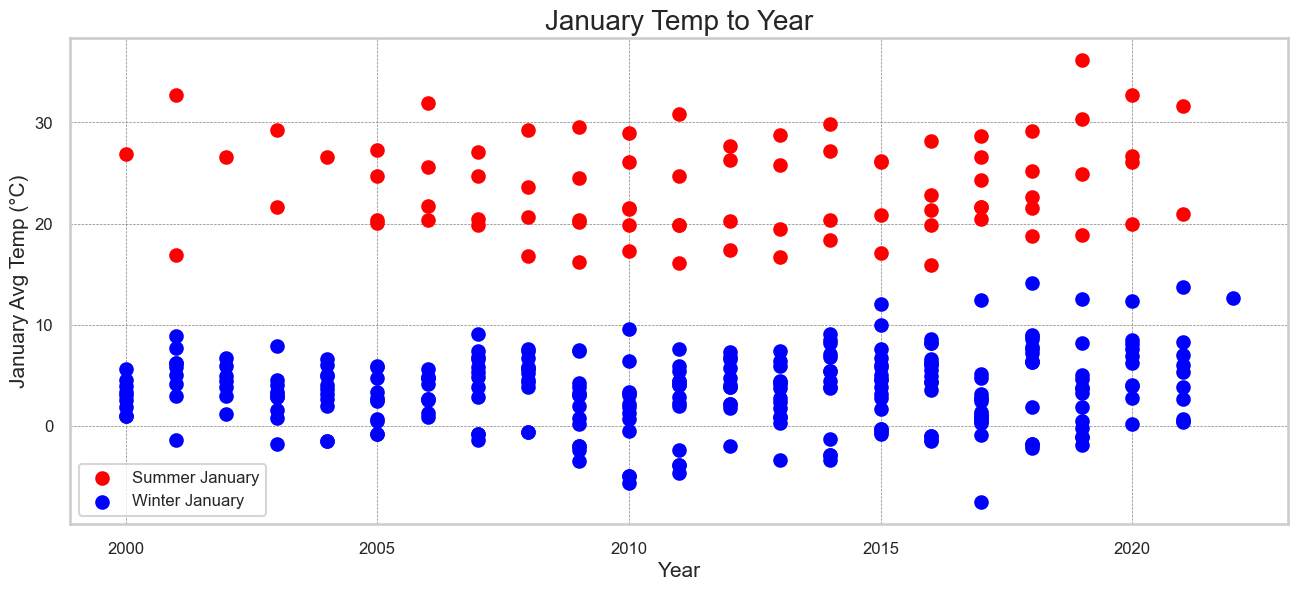

In [9]:
#Set out figure size
plt.figure(figsize=(14, 6))

# Sets out scatterplot
train_1 = train[(train['District'] == 'Clare and Gilbert Valleys') |
                (train['District'] == 'Unincorporated SA') | 
                (train['District'] == 'Onkaparinga') | 
                (train['District'] == 'Yarra Ranges') |
                (train['District'] == 'Barossa') |    
                (train['District'] == 'San Rafael') |
                (train['District'] == 'Luján de Cuyo') |
                (train['District'] == 'Presidente Roque Sáenz Peña')  
                ] 

train_2 = train[(train['District'] != 'Clare and Gilbert Valleys') &
                (train['District'] != 'Unincorporated SA') & 
                (train['District'] != 'Onkaparinga') &
                (train['District'] != 'Yarra Ranges') &
                (train['District'] != 'Barossa') &
                (train['District'] != 'San Rafael') &
                (train['District'] != 'Luján de Cuyo') &
                (train['District'] != 'Presidente Roque Sáenz Peña')  
                ] 

plt.scatter(x = train_1['Year'], y = train_1['January Avg Temp (°C)'], label = 'Summer January', color = 'red')
plt.scatter(x = train_2['Year'], y = train_2['January Avg Temp (°C)'], label = 'Winter January', color = 'blue')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('January Avg Temp (°C)')
plt.title('January Temp to Year')
plt.legend()

#Show the plot
plt.show()

Looking at the above plot, two distinct zones of temperatures can be seen. This corresponds to the predicted results for the different global january temperatures. Looking at the plot, 14°C will be used as the delinator to separate the two chunks of data.

Since this third model is being used to compare to the machine learning model 1, we wont split up the data. Additionally, machine learning model 1 showed that when we split up the data, because these models have so few data points, the accuracy decreases signifcantly.

---
# Model 1 - All Data

## Selecting and Splitting Data


In [10]:
train = Cleaning_Data(train)
train = Features(train)

X_data = Feature_Selection(train)
y_data = train['Ratings_Average']

model = RandomForestRegressor() 

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size = 0.8, random_state = 42)


### Training and Evaluating a Model

Simple model initially to iterate quickly to check r2 scores

Following this, hyperparameters were determined for the final submissions

In [11]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

0.7414856125304289


### Evaluating features

Iterated through this evaluation code to determine best combination of the many features and how many should be included


Top 15 Important Features:
                    Feature  Importance
13                   Tannin    0.201971
11                  Acidity    0.115132
6   Winter_Avg_Daylight_Hrs    0.111899
12                Intensity    0.110522
8   Summer_Avg_Daylight_Hrs    0.072192
2          Winter_Avg_Humid    0.066416
1           Summer_Avg_Temp    0.063040
7   Spring_Avg_Daylight_Hrs    0.056564
9      Summer_Temp_Humidity    0.047026
3          Spring_Avg_Humid    0.041497
5    Summer_Avg_Cloud_Cover    0.037603
4         Summer_Avg_Precip    0.029606
0                      Year    0.023761
10       Fall_Temp_Humidity    0.022770


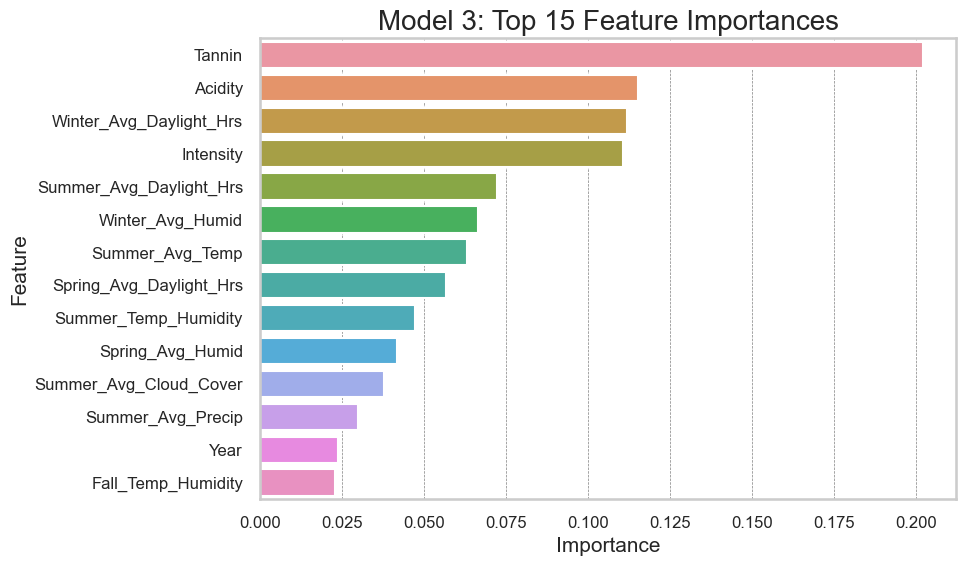

In [12]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Model 3: Top 15 Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()